In [127]:
using PlotlyJS
using Plots
using PyCall
using Printf
using LsqFit
using LinearAlgebra
using Statistics
# using Distributed
# using Base.Threads
using Pkg
using Optim
gr()  

Plots.GRBackend()

In [185]:
include("ABC.jl")

hartreeToWavenumberConversion::Float64 = 2.194746354e5
convertToRadians::Float64 = pi/180

inputFileName::String = "HOCl-VQZ-fit"
# inputFileName::String = "HOCl-VQZ-1D-rOH"
potentialInputFilePath::String = inputFileName*".inp"

keywords::Vector{String} = ["structural", "linear", "grid"]
inputBlocks::Vector{Vector{String}} = []
open(potentialInputFilePath, "r") do potentialInputFile::IOStream
    input::Vector{String} = readlines(potentialInputFile)
    addToBlock::Bool = false
    for keyword in keywords
        newBlock::Vector{String} = []
        for line in input
            if lowercase(line) == lowercase(keyword)
                addToBlock = true
            elseif lowercase(line) == "end"
                addToBlock = false
            end
            if addToBlock
                push!(newBlock, line)
            end
        end
        push!(inputBlocks, newBlock)
    end
end

structuralParameterBlock::Vector{String} = inputBlocks[1][2:end]
numberOfStructuralParameters::Int64 = size(structuralParameterBlock)[1] - 1
structuralParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(structuralParameterBlock, r"\s+")
numberOfMorseParameters::Int64 = parse(Int64, structuralParameterBlockSplit[1][2])
numberOfEquilibriumParameters::Int64 = numberOfStructuralParameters - numberOfMorseParameters
numberOfModes::Int64 = size(structuralParameterBlockSplit[2])[1] - 3
numberOfAtoms::Int64 = (numberOfModes + 6)/3
numberOfStretches::Int64 = numberOfAtoms - 1
numberOfBondAngles::Int64 = numberOfAtoms - 2
numberOfDihedrals::Int64 = numberOfAtoms - 3

structuralParameters::Vector{Float64} = zeros(numberOfStructuralParameters)
structuralParameterLabels::Vector{String} = []
structuralPowers::Matrix{Int64} = zeros(numberOfStructuralParameters, numberOfModes)
structuralParametersOn::Vector{Int64} = zeros(numberOfStructuralParameters)
for i in 1:numberOfStructuralParameters
    structuralParameters[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end])
    push!(structuralParameterLabels, String(structuralParameterBlockSplit[i + 1][1]))
    structuralPowers[i, :] = parse.(Int64, structuralParameterBlockSplit[i + 1][2:end-2])
    structuralParametersOn[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end - 1])
end

linearParameterBlock::Vector{String} = inputBlocks[2][2:end]
numberOfLinearParameters::Int64 = size(linearParameterBlock)[1]
linearParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(linearParameterBlock, r"\s+")

linearParameters::Vector{Float64} = zeros(numberOfLinearParameters)
linearParameterLabels::Vector{String} = []
linearPowers::Matrix{Int64} = zeros(numberOfLinearParameters, numberOfModes)
linearParametersOn::Vector{Int64} = zeros(numberOfLinearParameters)

for i in 1:numberOfLinearParameters
    linearParameters[i] = parse(Float64, linearParameterBlockSplit[i][end])
    push!(linearParameterLabels, String(linearParameterBlockSplit[i][1]))
    linearPowers[i, :] = parse.(Int64, linearParameterBlockSplit[i][2:end-2])
    linearParametersOn[i] = parse(Float64, linearParameterBlockSplit[i][end - 1])
end

allParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)
allPowers::Matrix{Int64} = vcat(structuralPowers, linearPowers)
allParametersOn::Vector{Int64} = vcat(structuralParametersOn, linearParametersOn)
numberOfParameters::Int64 = length(allParameters)
 
gridBlock::Vector{String} = inputBlocks[3][2:end]
numberOfGridPoints::Int64 = size(gridBlock)[1] 
gridBlockSplit::Vector{Vector{SubString{String}}} = split.(gridBlock, r"\s+")

grid::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
gridValenceCoordinates::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
energies::Vector{Float64} = zeros(numberOfGridPoints)

for i in 1:numberOfGridPoints
    grid[i, :]  = parse.(Float64, gridBlockSplit[i][1:numberOfModes])
    gridValenceCoordinates[i, :] = defineInternalCoordinates(grid[i, :])
    energies[i] = parse(Float64, gridBlockSplit[i][numberOfModes+1])
end


energies = energies.*hartreeToWavenumberConversion
minimumEnergy = minimum(energies)
println()
# @printf("%12.10f \n", minimumEnergy)
energies = energies.-minimumEnergy

# energiesScaled::Vector{Float64} = energies./(maximum(energies))

# Weight factor by Partridge and Schwenke
function computeWeightOfPoint(energy::Float64, energyThreshold=15000.0::Float64, energyMax=10000.0::Float64)::Float64
    weight::Float64 = (tanh(−0.0006*(energy - energyThreshold)) + 1.002002002)/2.002002002
    if energy > energyMax
        weight = weight/(0.0001*energy)
    else
        weight = weight/(0.0001*energyMax)
    end
    return weight
end

weights::Vector{Float64} = computeWeightOfPoint.(energies)
weightsSqrt::Vector{Float64} = sqrt.(weights)



function generateXiMatrix(gridValenceCoordinates::Matrix{Float64}, structuralParameters::Vector{Float64})::Matrix{Float64} 
    xiMatrix::Matrix{Float64} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        xi::Vector{Float64} = defineXiCoordinates(gridValenceCoordinates[i, :], structuralParameters)
        for j in 1:numberOfLinearParameters
            xiMatrix[i, j] = prod(xi.^linearPowers[j, :])*weightsSqrt[i]
        end
    end
    return xiMatrix
end

function potentialEnergyModel(gridValenceCoordinates::Matrix{Float64}, structuralParametersToFit::Vector{Float64})::Vector{Float64}
    structuralParametersToFit = [structuralParametersOn[i] == 1 ? structuralParametersToFit[i] : structuralParameters[i] for i in 1:length(structuralParametersOn)]
    xiMatrix::Matrix{Float64} = generateXiMatrix(gridValenceCoordinates, structuralParametersToFit)
    global linearParameters = xiMatrix \ (energies.*weightsSqrt)
    predictedEnergies::Vector{Float64} = (xiMatrix*linearParameters)./weightsSqrt
    return predictedEnergies
end

@time result = curve_fit(potentialEnergyModel, gridValenceCoordinates, energies, structuralParameters)
# @time structuralParameters::Vector{Float64} = curve_fit(potentialEnergyModel, gridValenceCoordinates, energies, structuralParameters)


@time xiMatrix::Matrix{Float64} = generateXiMatrix(gridValenceCoordinates, structuralParameters)./weightsSqrt
# newLinearParameters = xiMatrix \ (energies.*weightsSqrt)


# Linear equation
# @time newLinearParameters::Vector{Float64} = xiMatrix \ (energies.*weightsSqrt)


 23.512353 seconds (173.24 M allocations: 14.153 GiB, 19.61% gc time, 0.71% compilation time: 81% of which was recompilation)
  0.148564 seconds (2.06 M allocations: 172.070 MiB, 18.41% gc time)


6132×162 Matrix{Float64}:
 1.0  0.0           0.0         0.0          …   0.0           0.0
 1.0  0.0           0.0         0.0             -0.0           0.0
 1.0  0.0           0.0         0.0              0.0           0.0
 1.0  0.0           0.0         0.0             -0.0           0.0
 1.0  0.0           0.0         0.0              0.0           0.0
 1.0  0.0           0.0         0.0          …  -0.0           0.0
 1.0  0.0           0.0         0.0              0.0           0.0
 1.0  0.0           0.0         0.0             -0.0           0.0
 1.0  0.0           0.0         0.0              0.0           0.0
 1.0  0.0           0.0         0.0             -0.0           0.0
 ⋮                                           ⋱   ⋮            
 1.0  0.000442598  -9.31137e-6  1.95893e-7       4.39738e-10   2.68405e-9
 1.0  0.102325     -0.032732    0.0104704       -3.70613e-9   -1.0111e-9
 1.0  0.0661979    -0.017032    0.00438216   …  -6.37204e-8   -6.30736e-8
 1.0  1.59117e-5   -

In [179]:
# [structuralParametersOn[i] == 1 ? structuralParameters[i] : structuralParameters[i] for i in 1:numberOfStructuralParameters]
dump(result)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}
  param: Array{Float64}((5,)) [0.964280723976668, 1.68888476, 103.0, 2.3, 1.0]
  resid: Array{Float64}((59,)) [-0.19552312326137197, -0.5050464363013969, 0.11434425303765838, -0.8095782208779205, 0.4186568747666435, -1.1033527259582456, 0.7127086726656202, -1.3805991272775486, 0.9922896499286793, -1.636243330883815  …  -0.7734576608690986, -2.5882196135971753, 28.65064497038111, 3.1667933041171636, -10.861511496412277, -52.94659794828476, -102.7717623465469, -120.80023078196609, -65.92735273157086, 90.89030689503124]
  jacobian: Array{Float64}((59, 5)) [-189.68998552863434 0.0 … 0.0 0.0; 1859.2506641559482 0.0 … 0.0 0.0; … ; 399435.4488762202 0.0 … 0.0 0.0; 642902.5202495665 0.0 … 0.0 0.0]
  converged: Bool true
  trace: Array{LsqFit.LMState{LsqFit.LevenbergMarquardt}}((0,))
  wt: Array{Float64}((0,)) Float64[]


In [180]:
result.param

5-element Vector{Float64}:
   0.964280723976668
   1.68888476
 103.0
   2.3
   1.0

In [181]:
residuals::Vector{Float64} = energies .- (xiMatrix*linearParameters)

59-element Vector{Float64}:
   0.2021845440542008
   0.137597526952578
   0.25333464254071014
   0.05451464283424201
   0.2973476208872903
  -0.05325201119211442
   0.33932016859415626
  -0.19190627669088656
   0.3838426663792802
  -0.3669663653310238
   ⋮
  10.90129255978718
 -99.30174057437398
   4.986286492483487
  18.3228769319212
  59.460061812958884
 108.27147982026872
 125.33673132909098
  69.60982556617819
 -87.93276330182925

In [182]:
sqrt(mean((residuals.*weights).^2))

6.126316487867102

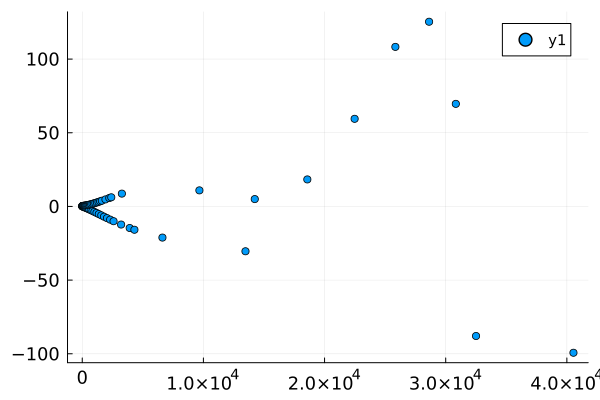

In [183]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
)

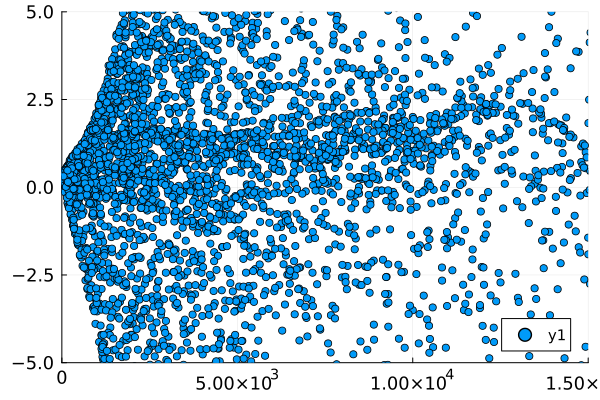

In [170]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
    xlimits=(0,15000),
    ylimits=(-5, 5)
)

In [ ]:
residuals = weighted

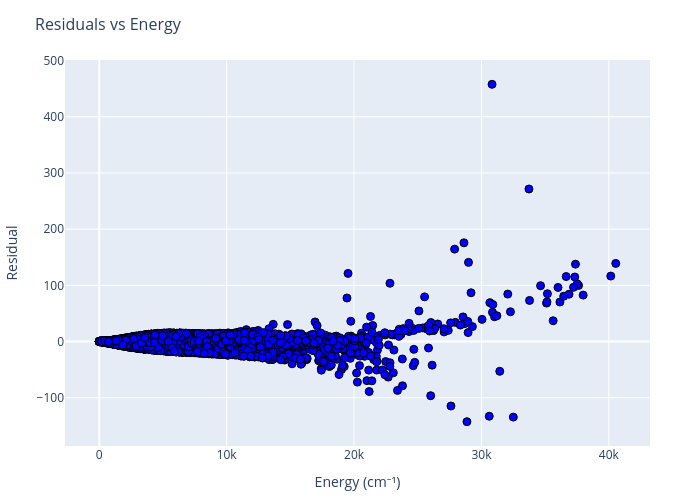

In [171]:
trace = PlotlyJS.scatter(
    x = energies,
    y = residuals,
    mode = "markers",  # for dots only
    marker = attr(
        size = 8,
        color = "blue",
        line = attr(width=1, color="black")
    ),
    name = "Residuals"
)

layout = PlotlyJS.Layout(
    title = attr(text="Residuals vs Energy", font=attr(size=16)),
    xaxis = attr(
        title = attr(text="Energy (cm⁻¹)", font=attr(size=14)),
        # range = [0, 15000],
        tickfont = attr(size=12)
    ),
    yaxis = attr(
        title = attr(text="Residual", font=attr(size=14)),
        tickfont = attr(size=12)
    ),
    legend = attr(font=attr(size=10))
)

PlotlyJS.plot(trace, layout)

In [105]:
structuralParameters
println(numberOfAtoms)
println(numberOfStretches)
println(numberOfBondAngles)
println(numberOfDihedrals)
println(numberOfGridPoints)
println(numberOfLinearParameters)
println(size(grid))
zeros(size(grid))
linearParametersOn
println(length(residuals))

3
2
1
0
6132
162
(6132, 3)
6132


In [110]:
xiMatrix

6132×162 Matrix{Float64}:
 1.0       0.0           0.0         …   0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0         …  -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 ⋮                                   ⋱   ⋮            
 1.0       0.000442598  -9.31137e-6      4.39738e-10   2.68405e-9
 0.99999   0.102324     -0.0327317      -3.70609e-9   -1.01109e-9
 0.999999  0.0661979    -0.017032    …  -6.37204e-8   -6.30735e-8
 0.998854  1.58935e-5   -6.33983e-8     -5.46561e-7    3.89768e-6
 0.984822  0.369534     -0.226362        9.39215e-10  -1.15066e-9

(Ngrid x Nparam) x Nparam = nGrid

In [ ]:
xiMatrix::Matrix{Float64} = zeros(numberOfGridPoints, numberOfLinearParameters)

In [19]:
linearPowers
grid

6132×3 Matrix{Float64}:
 0.964462  1.68888  103.0
 0.959462  1.68888  103.0
 0.969462  1.68888  103.0
 0.954462  1.68888  103.0
 0.974462  1.68888  103.0
 0.949462  1.68888  103.0
 0.979462  1.68888  103.0
 0.944462  1.68888  103.0
 0.984462  1.68888  103.0
 0.939462  1.68888  103.0
 ⋮                  
 0.90976   1.66716  104.24
 0.987089  1.89453  123.013
 1.01684   1.81067  118.832
 1.25891   1.62217  103.235
 0.939755  1.73779  146.878
 0.922218  1.65914  152.591
 1.35633   1.73672   95.7518
 0.982144  1.69171   74.334
 0.907359  1.64528  112.508

In [1]:

# addprocs(4)


# How many MEP parameters for each stretch/bend - order of input file matters!
numberOfParametersRCO::Int64 = sum(occursin.(r"rCO", structuralParameterLabels))
numberOfParametersROH::Int64 = sum(occursin.(r"rOH", structuralParameterLabels))
numberOfParametersRCH::Int64 = sum(occursin.(r"rCH", structuralParameterLabels))
numberOfParametersAHOC::Int64 = sum(occursin.(r"aHOC", structuralParameterLabels))
numberOfParametersAHCO::Int64 = sum(occursin.(r"aHCO", structuralParameterLabels))


# CH3OH
function potentialEnergy(internalCoordinates::Vector{Float64}, parameters::Vector{Float64})::Float64
    # Obtain MEP parameters for each stretch and bend
    parameterLowerRange::Int64 = 1
    parameterUpperRange::Int64 = numberOfParametersRCO
    # powersRCO::Matrix{Float64} = structuralPowers[1:parameterUpperRange, :]
    # parametersRCO::Vector{Float64} = parameters[1:parameterUpperRange]
    rCOeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[1:parameterUpperRange,:], parameters[1:parameterUpperRange])
    parameterUpperRange += numberOfParametersROH
    parameterLowerRange += numberOfParametersRCO
    # powersROH::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersROH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rOHeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersRCH
    parameterLowerRange += numberOfParametersROH
    # powersRCH::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersRCH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rCH1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHOC
    parameterLowerRange += numberOfParametersRCH
    # powersAHOC::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersAHOC::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHOCeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHCO
    parameterLowerRange += numberOfParametersAHOC
    # powersAHCO::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersAHCO::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHCO1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterLowerRange += numberOfParametersAHCO
    morseParameters::Vector{Float64} = parameters[parameterLowerRange:parameterLowerRange + numberOfMorseParameters - 1]

    # println(rCOeq)
    # println(rOHeq)
    # println(rCH1eq)
    # println(rCH2eq)
    # println(rCH3eq)
    # println(aHOCeq)
    # println(aHCO1eq)
    # println(aHCO2eq)
    # println(aHCO3eq)

    xi::Vector{Float64} = zeros(numberOfModes - 1)
    # Stretches
    xi[1] = 1 - exp(-morseParameters[1]*(internalCoordinates[1] - rCOeq))
    xi[2] = 1 - exp(-morseParameters[2]*(internalCoordinates[2] - rOHeq))
    xi[3] = 1 - exp(-morseParameters[3]*(internalCoordinates[3] - rCH1eq))
    xi[4] = 1 - exp(-morseParameters[3]*(internalCoordinates[4] - rCH2eq))
    xi[5] = 1 - exp(-morseParameters[3]*(internalCoordinates[5] - rCH3eq))

    # Bending
    xi[6] = (internalCoordinates[6] - aHOCeq)*convertToRadians
    xi[7] = (internalCoordinates[7] - aHCO1eq)*convertToRadians
    xi[8] = (internalCoordinates[8] - aHCO2eq)*convertToRadians
    xi[9] = (internalCoordinates[9] - aHCO3eq)*convertToRadians

    # Dihedrals
    xi[10] = internalCoordinates[10]
    xi[11] = internalCoordinates[11]
    
    parameterLowerRange += numberOfMorseParameters
    parameterUpperRange = size(parameters)[1]
    
    symmetryOperations::Array{Float64} = defineSymmetryOperations()
    numberOfSymmetryOperations::Int64 = size(symmetryOperations)[1]

    potential::Float64 = 0.0

    for i in 1:numberOfSymmetryOperations
        tau::Float64 = symmetryOperationsTau[i](internalCoordinates[12])
        xiTransformed::Vector{Float64} = symmetryOperations[i, :, :]*xi
        for j in parameterLowerRange:parameterUpperRange
            if linearPowers[j - parameterLowerRange + 1, end] >= 0
                potential += cos(linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])*parameters[j]
            else
                potential += sin(-linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])*parameters[j]
            end
        end
    end
    potential /= 6
end

# Here we define a function which ensures parameters not currently in the fit are unchanged
function potentialEnergyOfGrid(gridInternalCoordinates::Matrix{Float64}, parameters::Vector{Float64})::Vector{Float64}
    # parameters = [allParametersOn[i] == 1 ? parameters[i] : allParameters[i] for i in 1:length(allParametersOn)]
    numberOfPoints::Int64 = size(gridInternalCoordinates)[1]
    predictedEnergies::Vector{Float64} = zeros(numberOfPoints)
    for i in 1:numberOfPoints
        predictedEnergies[i] = potentialEnergy(gridInternalCoordinates[i, :], parameters)
    end
    return predictedEnergies
end

function lossGrid(parameters::Vector{Float64}, gridInternalCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64})::Float64
    predictedEnergies::Vector{Float64} = potentialEnergyOfGrid(gridInternalCoordinates::Matrix{Float64}, parameters::Vector{Float64})
    residuals::Vector{Float64} = energies - predictedEnergies
    return sum(weights .*abs2.(predictedEnergies))
end

function computeJacobianAtPoint(internalCoordinates::Vector{Float64}, parameters::Vector{Float64})::Vector{Float64}
    numberOfParameters::Int64 = length(parameters)
    derivatives::Vector{Float64} = zeros(numberOfParameters)
    
    # Obtain MEP parameters for each stretch and bend
    parameterLowerRange::Int64 = 1
    parameterUpperRange::Int64 = numberOfParametersRCO
    powersRCO::Matrix{Int64} = structuralPowers[1:parameterUpperRange, :]
    parametersRCO::Vector{Float64} = parameters[1:parameterUpperRange]
    rCOeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[1:parameterUpperRange,:], parameters[1:parameterUpperRange])
    parameterUpperRange += numberOfParametersROH
    parameterLowerRange += numberOfParametersRCO
    powersROH::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersROH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rOHeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersRCH
    parameterLowerRange += numberOfParametersROH
    powersRCH::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersRCH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rCH1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHOC
    parameterLowerRange += numberOfParametersRCH
    powersAHOC::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersAHOC::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHOCeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHCO
    parameterLowerRange += numberOfParametersAHOC
    powersAHCO::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersAHCO::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHCO1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterLowerRange += numberOfParametersAHCO
    morseParameters::Vector{Float64} = parameters[parameterLowerRange:parameterLowerRange + numberOfMorseParameters - 1]

    # println(rCOeq)
    # println(rOHeq)
    # println(rCH1eq)
    # println(rCH2eq)
    # println(rCH3eq)
    # println(aHOCeq)
    # println(aHCO1eq)
    # println(aHCO2eq)
    # println(aHCO3eq)

    xi::Vector{Float64} = zeros(numberOfModes - 1)
    # Stretches
    xi[1] = 1 - exp(-morseParameters[1]*(internalCoordinates[1] - rCOeq))
    xi[2] = 1 - exp(-morseParameters[2]*(internalCoordinates[2] - rOHeq))
    xi[3] = 1 - exp(-morseParameters[3]*(internalCoordinates[3] - rCH1eq))
    xi[4] = 1 - exp(-morseParameters[3]*(internalCoordinates[4] - rCH2eq))
    xi[5] = 1 - exp(-morseParameters[3]*(internalCoordinates[5] - rCH3eq))

    # Bending
    xi[6] = (internalCoordinates[6] - aHOCeq)*convertToRadians
    xi[7] = (internalCoordinates[7] - aHCO1eq)*convertToRadians
    xi[8] = (internalCoordinates[8] - aHCO2eq)*convertToRadians
    xi[9] = (internalCoordinates[9] - aHCO3eq)*convertToRadians

    # Dihedrals
    xi[10] = internalCoordinates[10]
    xi[11] = internalCoordinates[11]
    
    parameterLowerRange += numberOfMorseParameters
    parameterUpperRange = size(parameters)[1]
    
    symmetryOperations::Array{Float64} = defineSymmetryOperations()
    numberOfSymmetryOperations::Int64 = size(symmetryOperations)[1]

    for i in 1:numberOfSymmetryOperations
        xiTransformed::Vector{Float64} = symmetryOperations[i, :, :]*xi
        internalCoordinatesTransformed::Vector{Float64} = symmetryOperations[i, :, :]*internalCoordinates[1:end-1]
        tau::Float64 = symmetryOperationsTau[i](internalCoordinates[12])
        # Derivatives of CO MEP parameters
        for j in 1:numberOfParametersRCO
            if allParametersOn[j] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if linearPowers[k - parameterLowerRange + 1, 1] == 0
                        continue
                    end
                    if powersRCO[j, end] >= 0
                        newTerm += -morseParameters[1]*linearPowers[k - parameterLowerRange + 1, 1]*exp(-morseParameters[1]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO)))*xiTransformed[1]^(linearPowers[k - parameterLowerRange + 1, 1] - 1)*prod(xiTransformed[2:end].^linearPowers[k - parameterLowerRange + 1, 2:end-1])*cos(powersRCO[j, end]*tau)
                    else
                        newTerm += -morseParameters[1]*linearPowers[k - parameterLowerRange + 1, 1]*exp(-morseParameters[1]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO)))*xiTransformed[1]^(linearPowers[k - parameterLowerRange + 1, 1] - 1)*prod(xiTransformed[2:end].^linearPowers[k - parameterLowerRange + 1, 2:end-1])*sin(-powersRCO[j, end]*tau)
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j] += newTerm*parameters[k] 
                end
            end
        end
        # Derivatives of OH MEP parameters
        for j in 1:numberOfParametersROH
            if allParametersOn[j + numberOfParametersRCO] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if linearPowers[k - parameterLowerRange + 1, 2] == 0
                        continue
                    end
                    if powersROH[j, end] >= 0
                        newTerm += -morseParameters[2]*linearPowers[k - parameterLowerRange + 1, 2]*exp(-morseParameters[2]*(internalCoordinatesTransformed[2] - obtainCoordinateMEP(tau, powersROH, parametersROH)))*xiTransformed[2]^(linearPowers[k - parameterLowerRange + 1, 2] - 1)*xiTransformed[1]^linearPowers[k - parameterLowerRange + 1, 1]*prod(xiTransformed[3:end].^linearPowers[k - parameterLowerRange + 1, 3:end-1])*cos(powersROH[j, end]*tau)
                    else
                        newTerm += -morseParameters[2]*linearPowers[k - parameterLowerRange + 1, 2]*exp(-morseParameters[2]*(internalCoordinatesTransformed[2] - obtainCoordinateMEP(tau, powersROH, parametersROH)))*xiTransformed[2]^(linearPowers[k - parameterLowerRange + 1, 2] - 1)*xiTransformed[1]^linearPowers[k - parameterLowerRange + 1, 1]*prod(xiTransformed[3:end].^linearPowers[k - parameterLowerRange + 1, 3:end-1])*sin(-powersROH[j, end]*tau)
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO] += newTerm*parameters[k]  
                end
            end
        end
        # Derivatives of CH MEP parameters
        for j in 1:numberOfParametersRCH
            if allParametersOn[j + numberOfParametersRCO + numberOfParametersROH] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if powersROH[j, end] >= 0
                        if linearPowers[k - parameterLowerRange + 1, 3] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 3]*exp(-morseParameters[3]*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH)))*xiTransformed[3]^(linearPowers[k - parameterLowerRange + 1, 3] - 1)*prod(xiTransformed[1:2].^linearPowers[k - parameterLowerRange + 1, 1:2])*prod(xiTransformed[4:end].^linearPowers[k - parameterLowerRange + 1, 4:end-1])*cos(powersRCH[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 4] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 4]*exp(-morseParameters[3]*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3)))*xiTransformed[4]^(linearPowers[k - parameterLowerRange + 1, 4] - 1)*prod(xiTransformed[1:3].^linearPowers[k - parameterLowerRange + 1, 1:3])*prod(xiTransformed[5:end].^linearPowers[k - parameterLowerRange + 1, 5:end-1])*cos(powersRCH[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 5] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 5]*exp(-morseParameters[3]*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3)))*xiTransformed[5]^(linearPowers[k - parameterLowerRange + 1, 5] - 1)*prod(xiTransformed[1:4].^linearPowers[k - parameterLowerRange + 1, 1:4])*prod(xiTransformed[6:end].^linearPowers[k - parameterLowerRange + 1, 6:end-1])*cos(powersRCH[j, end]*(tau + 4*pi/3))
                        end
                    else
                        if linearPowers[k - parameterLowerRange + 1, 3] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 3]*exp(-morseParameters[3]*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH)))*xiTransformed[3]^(linearPowers[k - parameterLowerRange + 1, 3] - 1)*prod(xiTransformed[1:2].^linearPowers[k - parameterLowerRange + 1, 1:2])*prod(xiTransformed[4:end].^linearPowers[k - parameterLowerRange + 1, 4:end-1])*sin(-powersRCH[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 4] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 4]*exp(-morseParameters[3]*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3)))*xiTransformed[4]^(linearPowers[k - parameterLowerRange + 1, 4] - 1)*prod(xiTransformed[1:3].^linearPowers[k - parameterLowerRange + 1, 1:3])*prod(xiTransformed[5:end].^linearPowers[k - parameterLowerRange + 1, 5:end-1])*sin(-powersRCH[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 5] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 5]*exp(-morseParameters[3]*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3)))*xiTransformed[5]^(linearPowers[k - parameterLowerRange + 1, 5] - 1)*prod(xiTransformed[1:4].^linearPowers[k - parameterLowerRange + 1, 1:4])*prod(xiTransformed[6:end].^linearPowers[k - parameterLowerRange + 1, 6:end-1])*sin(-powersRCH[j, end]*(tau + 4*pi/3))
                        end
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO + numberOfParametersROH] += newTerm*parameters[k]
                end
            end
        end
        # Derivatives of aHOC MEP parameters
        for j in 1:numberOfParametersAHOC
            if allParametersOn[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if linearPowers[k - parameterLowerRange + 1, 6] == 0
                        continue
                    end
                    if powersROH[j, end] >= 0
                        newTerm += -linearPowers[k - parameterLowerRange + 1, 6]*xiTransformed[6]^(linearPowers[k - parameterLowerRange + 1, 6] - 1)*prod(xiTransformed[1:5].^linearPowers[k - parameterLowerRange + 1, 1:5])*prod(xiTransformed[7:end].^linearPowers[k - parameterLowerRange + 1, 7:end-1])*cos(powersAHOC[j, end]*tau)
                    else
                        newTerm += -linearPowers[k - parameterLowerRange + 1, 6]*xiTransformed[6]^(linearPowers[k - parameterLowerRange + 1, 6] - 1)*prod(xiTransformed[1:5].^linearPowers[k - parameterLowerRange + 1, 1:5])*prod(xiTransformed[7:end].^linearPowers[k - parameterLowerRange + 1, 7:end-1])*sin(-powersAHOC[j, end]*tau)
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH] += newTerm*parameters[k]
                end
            end
        end
        # Derivatives of aHCO MEP parameters
        for j in 1:numberOfParametersAHCO
            if allParametersOn[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH + numberOfParametersAHOC] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if powersROH[j, end] >= 0
                        if linearPowers[k - parameterLowerRange + 1, 7] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 7]*xiTransformed[7]^(linearPowers[k - parameterLowerRange + 1, 7] - 1)*prod(xiTransformed[1:6].^linearPowers[k - parameterLowerRange + 1, 1:6])*prod(xiTransformed[8:end].^linearPowers[k - parameterLowerRange + 1, 8:end-1])*cos(powersAHCO[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 8] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 8]*xiTransformed[8]^(linearPowers[k - parameterLowerRange + 1, 8] - 1)*prod(xiTransformed[1:7].^linearPowers[k - parameterLowerRange + 1, 1:7])*prod(xiTransformed[9:end].^linearPowers[k - parameterLowerRange + 1, 9:end-1])*cos(powersAHCO[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 9] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 9]*xiTransformed[9]^(linearPowers[k - parameterLowerRange + 1, 9] - 1)*prod(xiTransformed[1:8].^linearPowers[k - parameterLowerRange + 1, 1:8])*prod(xiTransformed[10:end].^linearPowers[k - parameterLowerRange + 1, 10:end-1])*cos(powersAHCO[j, end]*(tau + 4*pi/3))
                        end
                    else
                        if linearPowers[k - parameterLowerRange + 1, 7] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 7]*xiTransformed[7]^(linearPowers[k - parameterLowerRange + 1, 7] - 1)*prod(xiTransformed[1:6].^linearPowers[k - parameterLowerRange + 1, 1:6])*prod(xiTransformed[8:end].^linearPowers[k - parameterLowerRange + 1, 8:end-1])*sin(-powersAHCO[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 8] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 8]*xiTransformed[8]^(linearPowers[k - parameterLowerRange + 1, 8] - 1)*prod(xiTransformed[1:7].^linearPowers[k - parameterLowerRange + 1, 1:7])*prod(xiTransformed[9:end].^linearPowers[k - parameterLowerRange + 1, 9:end-1])*sin(-powersAHCO[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 9] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 9]*xiTransformed[9]^(linearPowers[k - parameterLowerRange + 1, 9] - 1)*prod(xiTransformed[1:8].^linearPowers[k - parameterLowerRange + 1, 1:8])*prod(xiTransformed[10:end].^linearPowers[k - parameterLowerRange + 1, 10:end-1])*sin(-powersAHCO[j, end]*(tau + 4*pi/3))
                        end
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH + numberOfParametersAHOC] += newTerm*parameters[k]
                end
            end
        end
        # Derivatives of morse parameters
        # rCO
        if allParametersOn[parameterLowerRange - 3] == 1
            for k in parameterLowerRange:parameterUpperRange
                newTerm::Float64 = 0
                if linearPowers[k - parameterLowerRange + 1, 1] == 0
                    continue
                end
                newTerm += linearPowers[k - parameterLowerRange + 1, 1]*exp(-morseParameters[1]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO)))*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO))*xiTransformed[1]^(linearPowers[k - parameterLowerRange + 1, 1] - 1)*prod(xiTransformed[2:end].^linearPowers[k - parameterLowerRange + 1, 2:end-1])
                if linearPowers[k - parameterLowerRange + 1, end] >= 0
                    newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                else
                    newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                end
                derivatives[parameterLowerRange - 3] += newTerm*parameters[k] 
            end
        end
        # rOH
        if allParametersOn[parameterLowerRange - 2] == 1
            for k in parameterLowerRange:parameterUpperRange
                newTerm::Float64 = 0
                if linearPowers[k - parameterLowerRange + 1, 2] == 0
                    continue
                end
                newTerm += linearPowers[k - parameterLowerRange + 1, 2]*exp(-morseParameters[2]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersROH, parametersROH)))*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO))*xiTransformed[2]^(linearPowers[k - parameterLowerRange + 1, 2] - 1)*prod(xiTransformed[3:end].^linearPowers[k - parameterLowerRange + 1, 3:end-1])*xiTransformed[1]^linearPowers[k - parameterLowerRange + 1, 1]
                if linearPowers[k - parameterLowerRange + 1, end] >= 0
                    newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                else
                    newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                end
                derivatives[parameterLowerRange - 2] += newTerm*parameters[k] 
            end
        end
        # rCH
        if allParametersOn[parameterLowerRange - 1] == 1
            for k in parameterLowerRange:parameterUpperRange
                newTerm::Float64 = 0
                if linearPowers[k - parameterLowerRange + 1, 3] > 0
                    newTerm += linearPowers[k - parameterLowerRange + 1, 3]*exp(-morseParameters[3]*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH)))*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH))*xiTransformed[3]^(linearPowers[k - parameterLowerRange + 1, 3] - 1)*prod(xiTransformed[1:2].^linearPowers[k - parameterLowerRange + 1, 1:2])*prod(xiTransformed[4:end].^linearPowers[k - parameterLowerRange + 1, 4:end-1])
                end
                if linearPowers[k - parameterLowerRange + 1, 4] > 0
                    newTerm += linearPowers[k - parameterLowerRange + 1, 4]*exp(-morseParameters[3]*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3)))*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3))*xiTransformed[4]^(linearPowers[k - parameterLowerRange + 1, 4] - 1)*prod(xiTransformed[1:3].^linearPowers[k - parameterLowerRange + 1, 1:3])*prod(xiTransformed[5:end].^linearPowers[k - parameterLowerRange + 1, 5:end-1])
                end
                if linearPowers[k - parameterLowerRange + 1, 5] > 0
                    newTerm += linearPowers[k - parameterLowerRange + 1, 5]*exp(-morseParameters[3]*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3)))*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3))*xiTransformed[5]^(linearPowers[k - parameterLowerRange + 1, 5] - 1)*prod(xiTransformed[1:4].^linearPowers[k - parameterLowerRange + 1, 1:4])*prod(xiTransformed[6:end].^linearPowers[k - parameterLowerRange + 1, 6:end-1])
                end
                if linearPowers[k - parameterLowerRange + 1, end] >= 0
                    newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                else
                    newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                end
                derivatives[parameterLowerRange - 1] += newTerm*parameters[k]
            end
        end
        # Derivatives of linear parameters
        for j in parameterLowerRange:parameterUpperRange
            if allParametersOn[j] == 1
                if linearPowers[j - parameterLowerRange + 1, end] >= 0
                    derivatives[j] += cos(linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])
                else
                    derivatives[j] += sin(-linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])
                end
            end
        end
    end
    derivatives ./= 6
end

function computeJacobianOnGrid(gridInternalCoordinates::Matrix{Float64}, parameters::Vector{Float64})::Matrix{Float64}
    numberOfGridPoints::Int64 = size(gridInternalCoordinates)[1]
    numberOfParameters::Int64 = length(parameters)
    jacobian::Matrix{Float64} = zeros(numberOfGridPoints, numberOfParameters)
    for i in 1:numberOfGridPoints
        jacobian[i, :] = computeJacobianAtPoint(gridInternalCoordinates[i, :], parameters)
    end
    return jacobian
end

function computeJacobianOnLossGrid(parameters::Vector{Float64}, gridInternalCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64})::Matrix{Float64}
    numberOfGridPoints::Int64 = size(gridInternalCoordinates)[1]
    numberOfParameters::Int64 = length(parameters)
    weightedResiduals::Vector{Float64} = 2*weights.*(energies .- lossGrid(allParameters, gridInternalCoordinates, energies, weights))
    jacobian::Matrix{Float64} = zeros(numberOfGridPoints, numberOfParameters)
    for i in 1:numberOfGridPoints
        jacobian[i, :] = weightedResiduals[i]*computeJacobianAtPoint(gridInternalCoordinates[i, :], parameters)
    end
    return jacobian
end

# @time res = optimize(allParameters -> lossGrid(allParameters, gridInternalCoordinates, energies, weights), allParameters -> computeJacobianOnLossGrid(allParameters, gridInternalCoordinates, energies, weights), allParameters, BFGS()) 
# newParams = Optim.minimizer(res)


@time fittedPotentialEnergy = curve_fit(potentialEnergyOfGrid, computeJacobianOnGrid, gridInternalCoordinates, energies, weights, allParameters)

fittedParameters::Vector{Float64} = fittedPotentialEnergy.param
computedEnergies::Vector{Float64} = potentialEnergyOfGrid(gridInternalCoordinates, fittedParameters)
residuals::Vector{Float64} = energies .- computedEnergies

open(inputFileName*".out", "w") do outputFile::IOStream
    println(outputFile, "New model:")
    for i in 1:numberOfParameters
        @printf(outputFile, "%4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %12.8f\n", allPowers[i, 1], allPowers[i, 2], allPowers[i, 3], allPowers[i, 4], allPowers[i, 5], allPowers[i, 6], allPowers[i, 7], allPowers[i, 8], allPowers[i, 9], allPowers[i, 10], allPowers[i, 11], allPowers[i, 12], fittedParameters[i])
    end
    println(outputFile, )
    println(outputFile, "Grid of energies:")
    for i in 1:numberOfGridPoints
        @printf(outputFile, "%12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f\n", grid[i, 1], grid[i, 2], grid[i, 3], grid[i, 4], grid[i, 5], grid[i, 6], grid[i, 7], grid[i, 8], grid[i, 9], grid[i, 10], grid[i, 11], grid[i, 12], energies[i], computedEnergies[i], residuals[i])
    end
end

SystemError: SystemError: opening file "/home/oleksiy_smola/Projects/HOCL/Potential/CH3OH.jl": No such file or directory

In [7]:
m::Float64 = 0.2
m + 5

5.2